# Libraries and Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import folium  # for creating interactive map

In [2]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Data Prep.

## Reading & First Observations 

In [3]:
mta = pd.read_csv("MTA_Subway_Hourly_Ridership__Beginning_February_2022_20240315.csv")
data = mta.copy()

In [4]:
data.head()

,transit_timestamp,transit_mode,station_complex_id,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Georeference
0,06/01/2023 12:00:00 AM,subway,52,Avenue U (Q),Brooklyn,omny,OMNY - Full Fare,3,0,40.599,-73.956,POINT (-73.9559326171875 40.599300384521484)
1,06/01/2023 12:00:00 AM,subway,52,Avenue U (Q),Brooklyn,metrocard,Metrocard - Unlimited 7-Day,3,0,40.599,-73.956,POINT (-73.9559326171875 40.599300384521484)
2,06/01/2023 12:00:00 AM,subway,53,Neck Rd (Q),Brooklyn,metrocard,Metrocard - Unlimited 30-Day,1,0,40.595,-73.955,POINT (-73.95516204833984 40.595245361328125)
3,06/01/2023 12:00:00 AM,subway,54,"Sheepshead Bay (B,Q)",Brooklyn,metrocard,Metrocard - Full Fare,6,0,40.587,-73.954,POINT (-73.95415496826172 40.58689498901367)
4,06/01/2023 12:00:00 AM,subway,54,"Sheepshead Bay (B,Q)",Brooklyn,metrocard,Metrocard - Other,2,0,40.587,-73.954,POINT (-73.95415496826172 40.58689498901367)


In [5]:
def dataset_summary(dataframe):
    """
    This function visually prints basic summary statistics of a given pandas DataFrame.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The DataFrame  to examine.
    Returns
    -------
    None
        The function only prints the outputs to the console and doesn't return any value.
    """
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### NULL VALUES #####################")
    print(dataframe.isnull().sum())
    print("##################### Descriptive Statistics #####################")
    print(dataframe.describe().T)

In [6]:
dataset_summary(data)

##################### Shape #####################
(6480346, 12)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6480346 entries, 0 to 6480345
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   transit_timestamp    object 
 1   transit_mode         object 
 2   station_complex_id   object 
 3   station_complex      object 
 4   borough              object 
 5   payment_method       object 
 6   fare_class_category  object 
 7   ridership            int64  
 8   transfers            int64  
 9   latitude             float64
 10  longitude            float64
 11  Georeference         object 
dtypes: float64(2), int64(2), object(8)
memory usage: 593.3+ MB
None
##################### NULL VALUES #####################
transit_timestamp      0
transit_mode           0
station_complex_id     0
station_complex        0
borough                0
payment_method         0
fare_class_category    

## Column infos

- transit_timestamp: Timestamp payment took place in local time. All transactions here are rounded down to the nearest hour.
- transit_mode: Distinguishes between the subway, Staten Island Railway, and the Roosevelt Island Tram
- station_complex: The subway complex where an entry swipe or tap took place. The subway complex name includes the routes that stop at the complex in parenthesis, such as Zerega Av (6).
- borough: Represents one of the boroughs of New York City serviced by the subway system (Bronx, Brooklyn, Manhattan, Queens).
- payment_method: Specifies whether the payment method used to enter was from OMNY or MetroCard.
- fare_class_category: The class of fare payment used for the trip.
- ridership: Total number of riders that entered a subway complex via OMNY or MetroCard at the specific hour and for that specific fare type.
- transfers: Number of individuals who entered a subway complex via a free bus-to-subway, or free out-of-network transfer. This represents a subset of total ridership, meaning that these transfers are already included in the preceding ridership column.
- Geoference: Open Data platform-generated geocoding information from supplied address components.  *Holds same info which given in latitude-longitude columns.*

## Conversion to date type

In [7]:
data["transit_timestamp"] = pd.to_datetime(data["transit_timestamp"], format="%m/%d/%Y %I:%M:%S %p")

*since Geoference is already exist in latitude and longitude it is irrelevant and complex names also exist in dataset*
*Payment methods, Fare Class Category cloums are also unnecessery for this project, but for now removing those columns might lead to
duplicated rows*

In [8]:
data.drop(["station_complex_id", "Georeference"], axis=1, inplace=True)

## Checking duplicated rows

In [9]:
data.duplicated().sum()

0

## Extracting Days, Months,Hours 

In [10]:
mapping = {
    6: "June",
    7: "July",
    8: "August",
    9: "September"
}

In [11]:
data["Month"] = data["transit_timestamp"].dt.month.map(mapping)
data["Day"] = data["transit_timestamp"].dt.day
data["Hour"] = data["transit_timestamp"].dt.hour

*dataset contains first day of september, lets filter it*


In [12]:
data = data[data["Month"] != "September"]

# Visualizations

*i'll use this function for groupby and aggregations*

In [13]:
def col_target_rel(dataframe, target, col, stats):
    """
    This function returns statistics related to a target variable based on a specified grouping column in a DataFrame.

    Parameters
    ----------
    dataframe : pandas.DataFrame
         The DataFrame containing the data.
    target : str
         The name of the target variable for which you want to calculate the aggregated statistics.
    col : str or list
        The name of the grouping column(s) based on which the aggregation will be performed.
    stats: str or list
        The statistic(s) to calculate for the target variable. It can be a single statistic (e.g., 'sum', 'mean')


    Returns
    -------
    result_table : pandas.DataFrame
        A DataFrame containing aggregated statistics for the target variable based on the specified grouping column(s).

    """
    result_table = dataframe.groupby(col).agg({target: stats}).reset_index()
    return result_table

## Passenger counts by transit mode

In [14]:
temp = col_target_rel(data, "ridership", "transit_mode", "sum")
temp

,transit_mode,ridership
0,staten_island_railway,502181
1,subway,284342725
2,tram,715262


<Axes: xlabel='transit_mode', ylabel='ridership'>

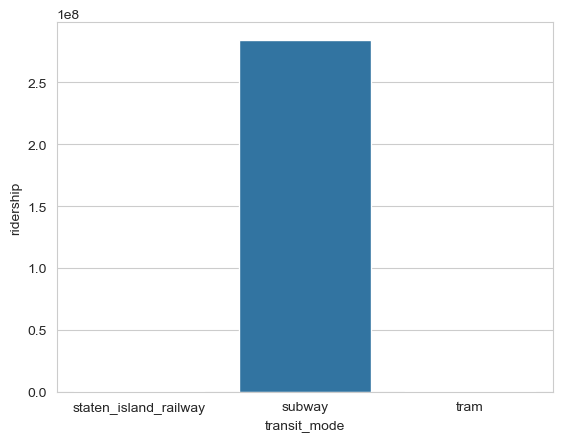

In [15]:
sns.barplot(x="transit_mode", y="ridership", data=temp)

*As you can see selecting subway is obvius choice, for makeing observations more deeper and sensetive, lets filter those data also*

In [16]:
data = data[data["transit_mode"] == "subway"]
data.drop("transit_mode", axis=1, inplace=True)  # since only 1 value left

## Monthly Total Passenger Counts

In [17]:
temp = col_target_rel(data, "ridership", "Month", "sum")
temp

,Month,ridership
0,August,94667797
1,July,91580673
2,June,98094255


<Axes: xlabel='Month', ylabel='ridership'>

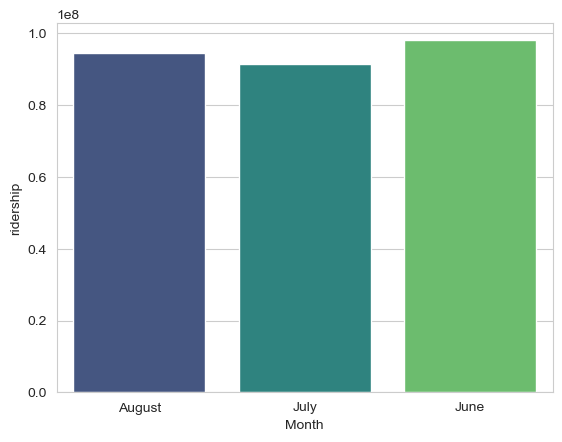

In [18]:
sns.barplot(x="Month", y="ridership", data=temp, palette="viridis")

* Total numbers looks similar but lets look weekly trends also*

In [19]:
data_time = data.set_index("transit_timestamp")  # converting dataset to timeseries data

<Axes: xlabel='transit_timestamp'>

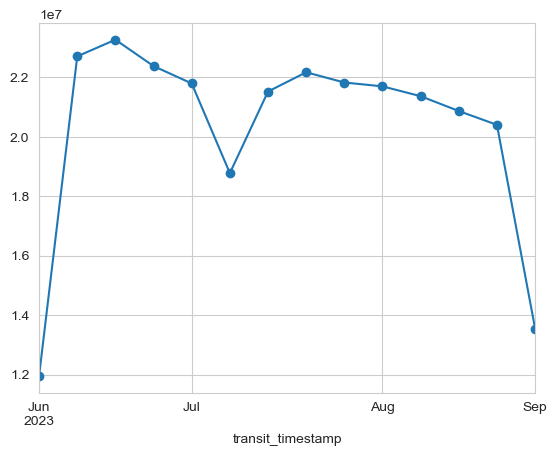

In [20]:
data_time["ridership"].resample("W").sum().plot(marker="o")

*If we consider the decrease in trend, it may be wise to stay away from the beginning of July.*

## Borough Total Passenger Counts

In [21]:
temp = col_target_rel(data, "ridership", "borough", "sum")

Text(0.5, 1.0, 'Percentage of Total Number of Passengers by Borough')

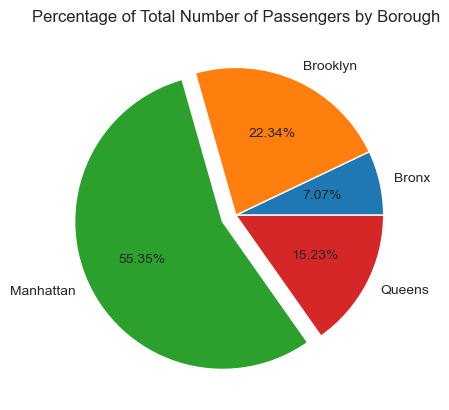

In [22]:
explode = (0,0,0.1,0)
plt.pie("ridership", labels = "borough", explode=explode, autopct= "%1.2f%%" ,data=temp)
plt.title("Percentage of Total Number of Passengers by Borough")

*State island is dissappeared because there is no subway connection to there, and as we can see in transit mode plot removing it made this graph more meaningful*

*Manhattan looks promising*

## Hourly Average Passenger Counts


In [23]:
temp = col_target_rel(data, "ridership", ["borough", "Day", "Hour"], "mean")

Text(0.5, 1.0, 'Hourly Avgerage Passengers')

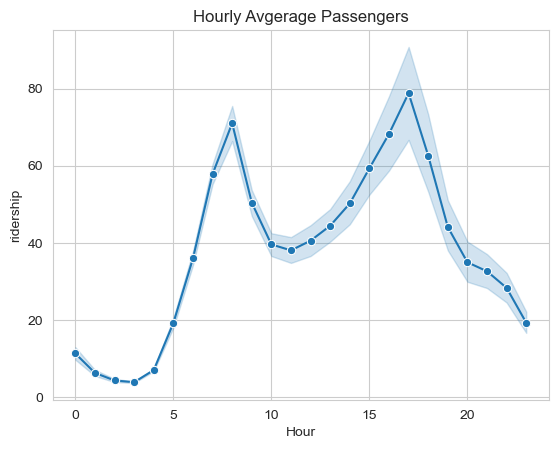

In [24]:
sns.lineplot(x='Hour', y='ridership', data=temp, marker="o")
plt.title("Hourly Avgerage Passengers")

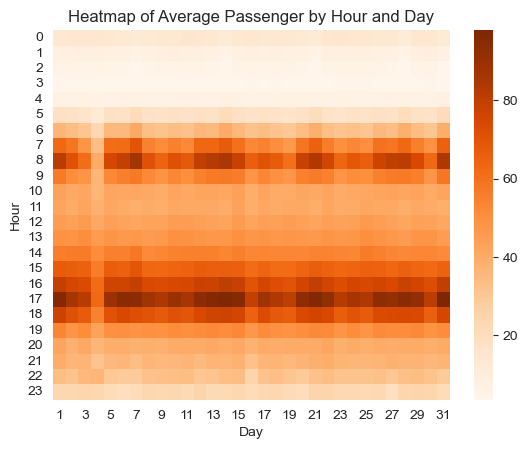

In [25]:
pivot_temp = data.pivot_table(index="Hour", columns="Day", values="ridership", aggfunc="mean")
sns.heatmap(pivot_temp, cmap="Oranges")
plt.title("Heatmap of Average Passenger by Hour and Day")
plt.show()

*As expected, the most crowded hours are the start of work and the end of work hours.*
*Lets consider boroughs too*

Text(0.5, 1.0, 'Hourly Avgerage Passenger Count Acoording to Boroughs')

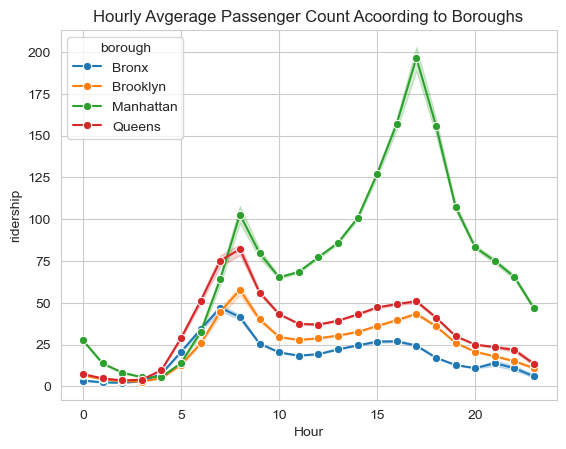

In [26]:
plt.figure()
sns.lineplot(x="Hour", y="ridership", data=temp, hue="borough", marker="o")
plt.title("Hourly Avgerage Passenger Count Acoording to Boroughs")

## Daily Average Passsenger Count

In [27]:
pivot_temp = data.pivot_table(index="borough", columns="Day", values="ridership", aggfunc="mean")

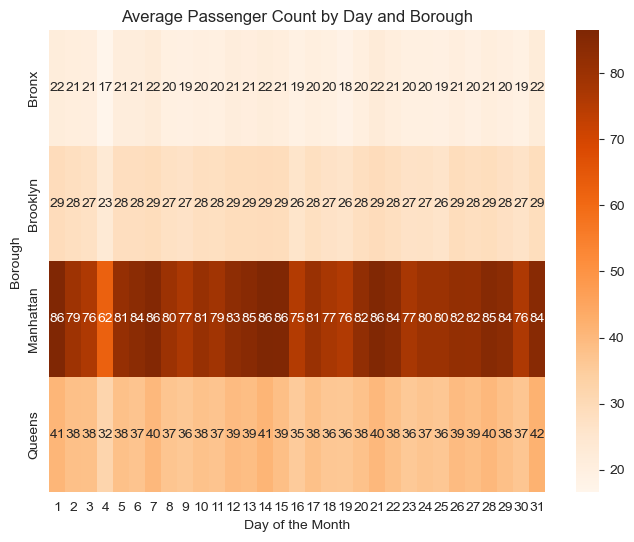

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_temp, cmap="Oranges", annot=True)
plt.title("Average Passenger Count by Day and Borough")
plt.xlabel("Day of the Month")
plt.ylabel("Borough")
plt.show()

*This heatmap showed us, Manhattan is more dense from other boroughs despite the day of month*

*If we summarize the observations so far, it is clear that Subway is by far the most preferred option, Manhattan has the highest passenger traffic, and the busiest hours in the area are between 16-18. Now that we know which area and time interval to choose, let's also look at the stations to be selected.*
- We could filter data but it's unnecessery

In [29]:
# it'll be usefull later
stations = col_target_rel(data, "ridership", ["station_complex", "borough"], "sum").sort_values(by="ridership",
                                                                                                ascending=False).reset_index(
    drop=True)
temp = stations.copy()

In [30]:
stations.head()

,station_complex,borough,ridership
0,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",Manhattan,11158020
1,"Grand Central-42 St (S,4,5,6,7)",Manhattan,7874361
2,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",Manhattan,5853469
3,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",Manhattan,5158760
4,"Fulton St (A,C,J,Z,2,3,4,5)",Manhattan,4598235


In [31]:
# i want to get rid of paranthesis for better visualization
temp["station_complex"] = temp["station_complex"].str.replace(r"\s*\([^)]*\)", "", regex=True)

In [32]:
temp.head(20)  # now it looks better

,station_complex,borough,ridership
0,Times Sq-42 St/42 St,Manhattan,11158020
1,Grand Central-42 St,Manhattan,7874361
2,34 St-Herald Sq,Manhattan,5853469
3,14 St-Union Sq,Manhattan,5158760
4,Fulton St,Manhattan,4598235
5,34 St-Penn Station,Manhattan,4329338
6,34 St-Penn Station,Manhattan,3809301
7,74-Broadway/Jackson Hts-Roosevelt Av,Queens,3764000
8,59 St-Columbus Circle,Manhattan,3743759
9,Flushing-Main St,Queens,3586031


Text(0.5, 1.0, 'Most Crowded Stations')

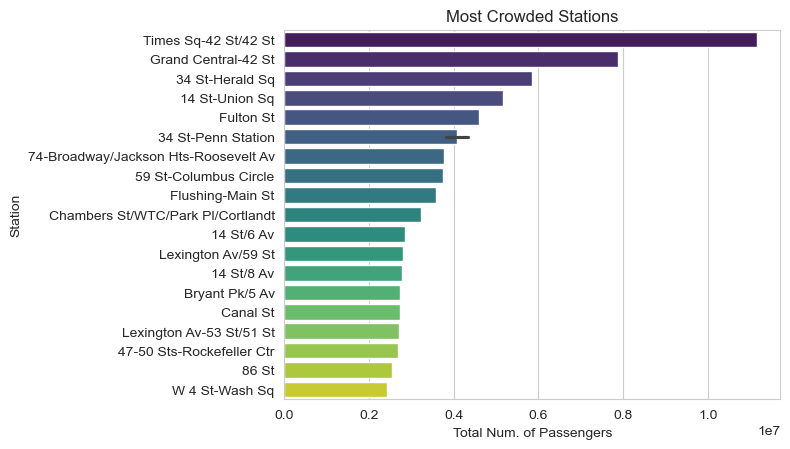

In [33]:
sns.barplot(x="ridership", y="station_complex", orient="h", data=temp.head(20), palette="viridis")
plt.xlabel("Total Num. of Passengers")
plt.ylabel("Station")
plt.title("Most Crowded Stations")

## Last decision step

*In this section i will put most crowded stations, their boroughs, their coordinates and their avg. passanger counts on a diffrent dataset and i will visualize results on a map*

In [34]:
stations["station_complex"]

0      Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)
1                       Grand Central-42 St (S,4,5,6,7)
2                     34 St-Herald Sq (B,D,F,M,N,Q,R,W)
3                      14 St-Union Sq (L,N,Q,R,W,4,5,6)
4                           Fulton St (A,C,J,Z,2,3,4,5)
                             ...                       
419                                     Beach 36 St (A)
420                                     Beach 44 St (A)
421                                   Beach 98 St (A,S)
422                                  Beach 105 St (A,S)
423                                 Broad Channel (A,S)
Name: station_complex, Length: 424, dtype: object

In [35]:
temp = data[data["station_complex"].isin(stations["station_complex"])]

In [36]:
temp.head()

,transit_timestamp,station_complex,borough,payment_method,fare_class_category,ridership,transfers,latitude,longitude,Month,Day,Hour
0,2023-06-01,Avenue U (Q),Brooklyn,omny,OMNY - Full Fare,3,0,40.599,-73.956,June,1,0
1,2023-06-01,Avenue U (Q),Brooklyn,metrocard,Metrocard - Unlimited 7-Day,3,0,40.599,-73.956,June,1,0
2,2023-06-01,Neck Rd (Q),Brooklyn,metrocard,Metrocard - Unlimited 30-Day,1,0,40.595,-73.955,June,1,0
3,2023-06-01,"Sheepshead Bay (B,Q)",Brooklyn,metrocard,Metrocard - Full Fare,6,0,40.587,-73.954,June,1,0
4,2023-06-01,"Sheepshead Bay (B,Q)",Brooklyn,metrocard,Metrocard - Other,2,0,40.587,-73.954,June,1,0


In [37]:
# lets make this dataset more usable
coords = temp[["station_complex", "latitude", "longitude"]].drop_duplicates().reset_index(drop=True)

In [38]:
coords

,station_complex,latitude,longitude
0,Avenue U (Q),40.599,-73.956
1,Neck Rd (Q),40.595,-73.955
2,"Sheepshead Bay (B,Q)",40.587,-73.954
3,"Brighton Beach (B,Q)",40.578,-73.961
4,Ocean Pkwy (Q),40.576,-73.968
...,...,...,...
479,"14 St (F,M,1,2,3)/6 Av (L)",40.737,-73.997
480,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",40.755,-73.987
481,"Court St (R)/Borough Hall (2,3,4,5)",40.694,-73.992
482,"Court St (R)/Borough Hall (2,3,4,5)",40.694,-73.990


*there is still a small issue left, in some columns there are 0.001 diffirence in latitude or longitude so that makes duplicate datas (possible mistake while registering data to MTA database)*

In [39]:
coords = coords.drop_duplicates(subset="station_complex")

*and finally... lets add average num of passengers*

In [40]:
final_data = pd.merge(coords, stations, on="station_complex").sort_values(by="ridership", ascending=False).reset_index(
    drop=True)

In [41]:
final_data

,station_complex,latitude,longitude,borough,ridership
0,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",40.757,-73.987,Manhattan,11158020
1,"Grand Central-42 St (S,4,5,6,7)",40.752,-73.977,Manhattan,7874361
2,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",40.750,-73.988,Manhattan,5853469
3,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",40.736,-73.990,Manhattan,5158760
4,"Fulton St (A,C,J,Z,2,3,4,5)",40.710,-74.007,Manhattan,4598235
...,...,...,...,...,...
419,Beach 36 St (A),40.595,-73.768,Queens,42445
420,Beach 44 St (A),40.593,-73.776,Queens,35900
421,"Beach 98 St (A,S)",40.585,-73.821,Queens,34274
422,"Beach 105 St (A,S)",40.583,-73.828,Queens,28104


*lets draw a map to see results*

In [42]:
map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)  # coordinates of new york city

In [43]:
color_map = folium.LinearColormap(["green", 'blue', 'red'], vmin=final_data["ridership"].min(), vmax=4e6,
                                  caption="ridership")

for index, row in final_data.head(20).iterrows():
    station = row["station_complex"]
    latitude = row["latitude"]
    longitude = row["longitude"]
    ridership = row["ridership"]
    borough = row['borough']
    size = ridership / 1000000  # adjusting radius according to ridership

    folium.CircleMarker(
        location=(latitude, longitude),
        radius=size,
        color=color_map(ridership),
        fill=True,
        fill_opacity=0.6,
    ).add_to(map)

    folium.Marker([latitude, longitude],
                  popup=f"<b>{station}</b><br>Num of Passengers: {ridership:,.0f}<br>Region: {borough}").add_to(map)

density_heat = final_data[['latitude', 'longitude', 'ridership']].values
color_map.add_to(map)



In [44]:
map

*it seems that those points are ideal for placing our teams and it matches with our visual insights*
*and you could observe detailed infos on this map*

In [45]:
map.save("subway_map.html")

# Suplementary Datas

In [46]:
insurance = pd.read_csv("Unemployment_Insurance_Beneficiaries_and_Benefit_Amounts_Paid__Beginning_2001_20240316.csv")
df = insurance.copy()

In [47]:
df.head()

,Year,Month,Region,County,Beneficiaries,Benefit Amounts (Dollars)
0,2001,1,New York City,Bronx,13800,12290000
1,2001,1,New York City,Kings,26900,23980000
2,2001,1,New York City,New York,17600,18990000
3,2001,1,New York City,Queens,20600,19850000
4,2001,1,New York City,Richmond,4300,4110000


In [48]:
dataset_summary(df)

##################### Shape #####################
(1385, 6)
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385 entries, 0 to 1384
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Year                         1385 non-null   int64 
 1   Month                        1385 non-null   int64 
 2   Region                       1385 non-null   object
 3   County                       1385 non-null   object
 4   Beneficiaries                1385 non-null   int64 
 5    Benefit Amounts (Dollars)   1385 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 65.0+ KB
None
##################### NULL VALUES #####################
Year                           0
Month                          0
Region                         0
County                         0
Beneficiaries                  0
 Benefit Amounts (Dollars)     0
dtype: int64
######

## Dataset and Columns Info
This dataset contains monthly counts, from 2001 to present, of individuals receiving regular unemployment insurance benefits, as well as the total amount of benefits received from New York State. I filtered this dataset to only include New York City.
- Dataset Link: https://data.ny.gov/Economic-Development/Unemployment-Insurance-Beneficiaries-and-Benefit-A/xbjp-8sra/about_data
- Beneficiaries: Number of individuals who receive unemployment insurance benefits. Counts of beneficiaries are rounded to the nearest 100.
- Benefit Amounts: Dollar amount of benefits disbursed to the unemployment insurance beneficiaries. Benefit Amounts are rounded to the nearest $10,000.
- Year: Starts from 2001
- Month: Numeric(1-2)
- Region: Filtered, just New York City
- County: Brox, Queens, New York(Manhattan), Kings(Brooklyn), Richmond(Staten Island)

## Monthly Number of Insurance Beneficiaries Trends

*Due to covid-19 epidemic, number of people who takes unemploeyment ins. increased dramaticly. That's why lets get rid of it for gathering meaningful graphs*
*2020-2021 years largely affected by covid.*

In [49]:
temp = df.loc[(df["Year"] >= 2010) & (df["Year"] != 2020) & (df["Year"] != 2021)].reset_index(drop=True)

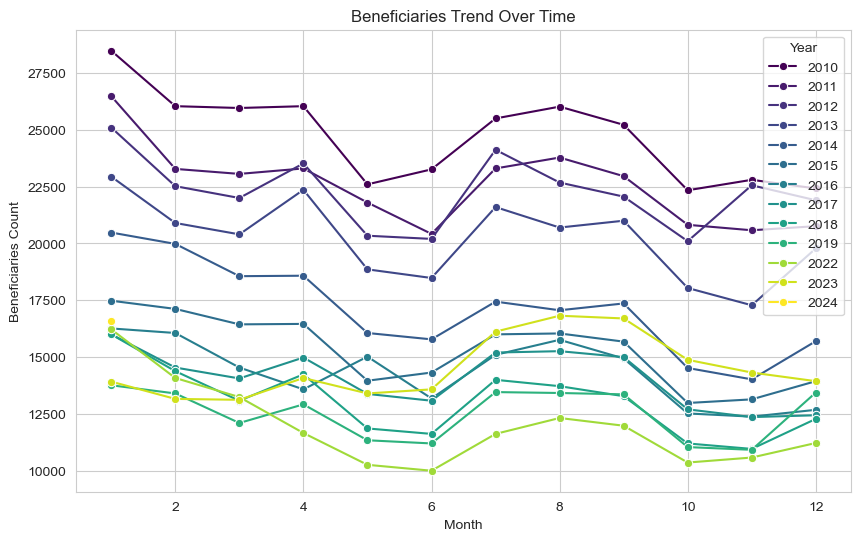

In [50]:
plt.figure(figsize=(10, 6))  # Grafiğin boyutunu ayarla
sns.lineplot(data=temp, x="Month", y="Beneficiaries", hue="Year", marker="o", palette="viridis", ci=None)  # Çizgi grafiğini oluştur
plt.title("Beneficiaries Trend Over Time")  # Grafiğin başlığını ayarla
plt.xlabel("Month")  # X ekseni etiketi
plt.ylabel("Beneficiaries Count")  # Y ekseni etiketi
plt.legend(title="Year", labels=temp["Year"].unique())  # Açıklamayı ekle
plt.show()  # Grafiği göster

*We could see that numbers always increased at summer, so it is wise decision to choose summer to organize this premiere*

## Working on Recent Data

In [51]:
# lets filter the data between 2023-2024
df = df.loc[(df["Year"] == 2023) | (df["Year"] == 2024)].reset_index(drop=True)

Text(0.5, 1.0, 'Number of Unemployment Insurance Beneficiaries in 2023')

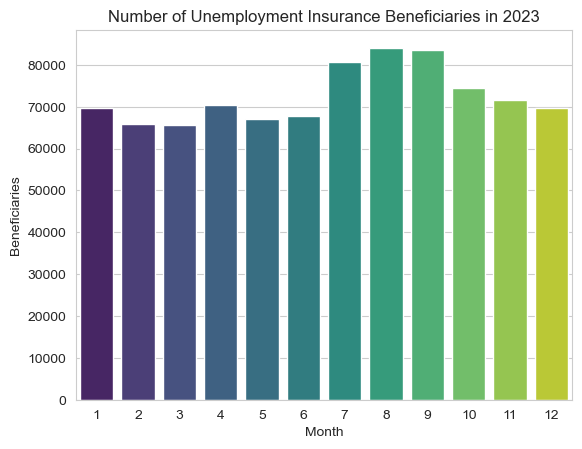

In [52]:
#firstly lets look distrubution of beneficaries in 2023
temp = df[df["Year"] == 2023]
temp = col_target_rel(temp, "Beneficiaries", "Month", "sum")
sns.barplot(x="Month", y="Beneficiaries", data=temp, palette="viridis")
plt.title("Number of Unemployment Insurance Beneficiaries in 2023")

## County Based Average Number of Benef. 

In [53]:
temp = col_target_rel(df, "Beneficiaries", "County", "mean").sort_values(by="Beneficiaries", ascending=False)

In [54]:
temp

,County,Beneficiaries
1,Kings,23769.231
3,Queens,17100.000
2,New York,14623.077
0,Bronx,14300.000
4,Richmond,3523.077


Text(0.5, 1.0, 'County Based Average Number of Beneficiaries')

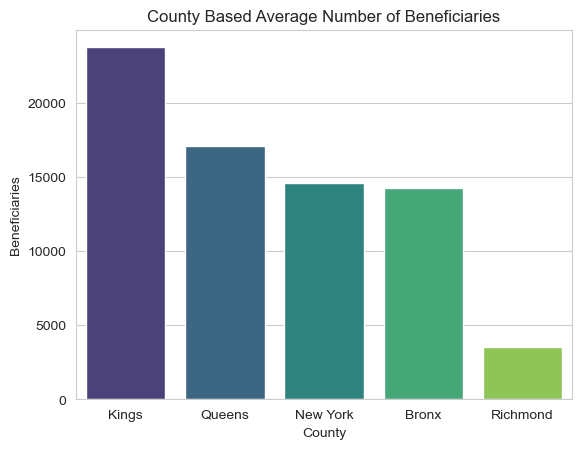

In [55]:
sns.barplot(x="County", y="Beneficiaries", data=temp, palette="viridis")
plt.title("County Based Average Number of Beneficiaries")

In [56]:
temp = col_target_rel(df, " Benefit Amounts (Dollars) ", "County", "sum").sort_values(by=" Benefit Amounts (Dollars) ",
                                                                                       ascending=False)

In [57]:
temp

,County,Benefit Amounts (Dollars)
1,Kings,466260000
3,Queens,331400000
2,New York,300820000
0,Bronx,256300000
4,Richmond,63130000


Text(0.5, 1.0, 'Total Unemployment Insurance Cost in 2023-2024')

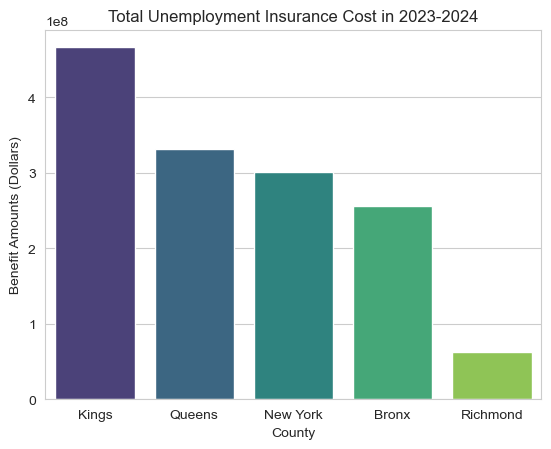

In [58]:
sns.barplot(x="County", y=" Benefit Amounts (Dollars) ", data=temp, palette="viridis")
plt.title("Total Unemployment Insurance Cost in 2023-2024")

*So according to this datas we should consider to send one of our teams to kings, now lets look at which station is the most crowded in Brooklyn*

In [59]:
kings = final_data[final_data["borough"] == "Brooklyn"].head(1)
kings

,station_complex,latitude,longitude,borough,ridership
21,"Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",40.684,-73.978,Brooklyn,2282182


In [60]:
final_data.head()

,station_complex,latitude,longitude,borough,ridership
0,"Times Sq-42 St (N,Q,R,W,S,1,2,3,7)/42 St (A,C,E)",40.757,-73.987,Manhattan,11158020
1,"Grand Central-42 St (S,4,5,6,7)",40.752,-73.977,Manhattan,7874361
2,"34 St-Herald Sq (B,D,F,M,N,Q,R,W)",40.750,-73.988,Manhattan,5853469
3,"14 St-Union Sq (L,N,Q,R,W,4,5,6)",40.736,-73.990,Manhattan,5158760
4,"Fulton St (A,C,J,Z,2,3,4,5)",40.710,-74.007,Manhattan,4598235


*To send a team to Brooklyn may reach fewer people, but directing one team here will be more efficient in reaching the __target audience__.*
*lets add Atlantic Station to also our map with*

In [61]:
temp = col_target_rel(df, "Beneficiaries", "County", "mean").sort_values(by="Beneficiaries", ascending=False)
temp.head(1)

,County,Beneficiaries
1,Kings,23769.231


In [62]:
new_point = (kings.iloc[0,1], kings.iloc[0,2])
station = kings.iloc[0,0]
ridership = kings.iloc[0,4]
borough = "Manhattan"
warning = f"Average Unemp. Beneficiaries : {temp.head(1).iloc[0,1]:,.0f}"

In [63]:
warning

'Average Unemp. Beneficiaries : 23,769'

In [64]:
folium.Marker(new_point, popup=f"<b>{station}</b><br>Num of Passengers: {ridership:,.0f}<br>Region: {borough}<br>{warning} ",
              icon=folium.Icon(color="orange")).add_to(map)

In [65]:
map

In [66]:
map.save("subway_map_updated.html")